# Lotka Volterra Equation Using Neural ODE

In [1]:
import torch
import torch.nn as nn
import torchdyn
import numpy as np
#from neuralode import NeuralODE, NeuralODEModel
from torchdyn.numerics.odeint import odeint, _fixed_odeint, _adaptive_odeint
from torchdiffeq import odeint as ode
import matplotlib.pyplot as plt

In [2]:
# TODO : Lotka Volterra Equation Using Neural ODE of deepchem
# Solve LV eq using odesolver
# learn the dynamics using neural ode

In [3]:
alpha = 1. #mortality rate due to predators
beta = 1.
delta = 1.
gamma = 1.

x0 = torch.Tensor([4.])
y0 = torch.Tensor([2.])

def derivative(t, X, **kwargs):
    x, y = X 
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)

    return torch.Tensor([dotx, doty])

In [4]:
Nt = 1000
tmax = 30.
t_span = torch.linspace(0.,tmax, Nt)

t_span.requires_grad = False
X0 = [x0, y0]
X0 = torch.Tensor(X0)

#res = integrate.odeint(derivative, X0, t, args = (alpha, beta, delta, gamma))
#print(X0.shape)
res = odeint(derivative, X0, t_span=t_span, solver='tsit5')


In [5]:
def series(res):
    t, X = res
    x,y = np.array([]), np.array([])
    with torch.no_grad():
        
        for val in X:
                    
            x = np.append(x,val[0])
            y = np.append(y,val[1])
        
    return x,y

x,y = series(res)


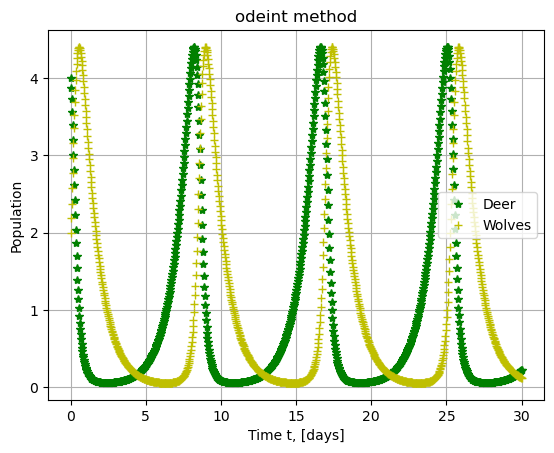

In [6]:
plt.figure()
plt.grid()
plt.title("odeint method")
plt.plot(t_span, x, '*g', label = 'Deer')
plt.plot(t_span, y, '+y', label = "Wolves")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()

plt.show()

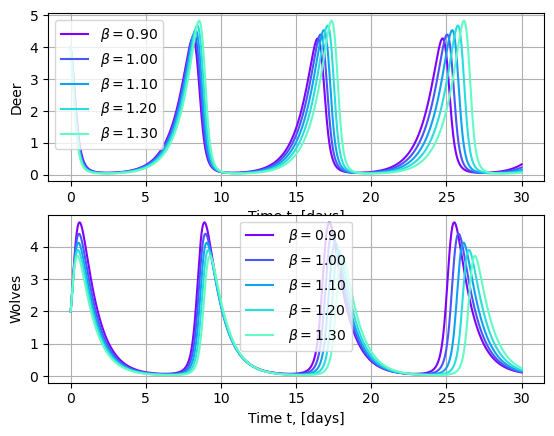

In [7]:
import random
import matplotlib.cm as cm


alpha = 1. #mortality rate due to predators
#beta = 1.
delta = 1.
gamma = 1.

betas = np.arange(0.9, 1.4, 0.1)

nums=np.random.random((10,len(betas)))
colors = cm.rainbow(np.linspace(0, 1, nums.shape[0]))  # generate the colors for each data set

fig, ax = plt.subplots(2,1)

for beta, i in zip(betas, range(len(betas))):
    res = odeint(derivative, X0, t_span, solver='tsit5')
    x,y = series(res)
    ax[0].plot(t_span, x, color = colors[i],  linestyle = '-', label = r"$\beta = $" + "{0:.2f}".format(beta))
    ax[1].plot(t_span, y, color = colors[i], linestyle = '-', label = r" $\beta = $" + "{0:.2f}".format(beta))
    ax[0].legend()
    ax[1].legend()

ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Time t, [days]')
ax[0].set_ylabel('Deer')
ax[1].set_xlabel('Time t, [days]')
ax[1].set_ylabel('Wolves');

#### So far, we have known the dynamics of the system, i.e. it's equations ! For a general system we would not be given it's differential equation,
#### we might need to model the system from it's input and output only, in that case we can use a neural network as a vector field of the ODE, and train
#### the system on a set of input and output of a system

In [8]:
import torch
import torch.nn as nn

import numpy as np
import torchdyn


import tqdm

## Given initial conditions, predict the predator and prey population at given point of time

In [9]:
class LotkaVolterraDataset(torch.utils.data.Dataset):

    def __init__(self, X):
        self.t, X = X
        
        self.x, self.y = np.array([]), np.array([])

        for val in X:
            #print(type(val[0]), val[0].requires_grad)
            val[0].requires_grad = True
            val[1].requires_grad = True
            
            self.x = np.append(self.x, val[0])
            self.y = np.append(self.y, val[1])
        
    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
              
        return self.t[idx], self.x[idx], self.y[idx]

res = odeint(derivative, X0, t_span, solver='tsit5')
dataset = LotkaVolterraDataset(res)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1000)
data_iter = iter(train_loader)


In [10]:
from torch.utils.data import TensorDataset
t, X = res

x_data, y_data = [], []
for val in X:
    x_data.append(val[0])
    y_data.append(val[1])

t.requires_grad = True
x_tensor = torch.tensor(x_data, requires_grad=True)
y_tensor = torch.tensor(y_data, requires_grad=True)

dataset = TensorDataset(t, x_tensor, y_tensor) 
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1000)
data_iter = next(iter(train_loader))

In [11]:
a, b, c = data_iter
print(a.requires_grad, b.requires_grad, c.requires_grad)


True True True


In [13]:
class f(nn.Module):
  def __init__(self, dim):
    super(f, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(dim,124),
        nn.ReLU(),
        nn.Linear(124,124),
        nn.ReLU(),
        nn.Linear(124,dim),
        nn.Tanh()
    )

  def forward(self, t, x):
    x = x.float()
    return self.model(x)

from torchdyn.core import NeuralODE

class DifferentialEquation(nn.Module):
  
  def __init__(self, 
               network:nn.Module = f(dim=1000), 
               t_span=torch.Tensor([0., 1.]), 
               solver='tsit5', 
               order=1, 
               atol=0.001, 
               rtol=0.001,
               sensitivity='autograd', 
               atol_adjoint=0.0001, 
               rtol_adjoint=0.0001, 
               interpolator = None, 
               integral_loss=None, 
               seminorm=False, 
               return_t_eval=True, 
               optimizable_params={}) -> None:

    super(DifferentialEquation, self).__init__()
    
    #self.input_layer = nn.Linear(1000,124)
    self.model = NeuralODE(vector_field=network, 
                  solver=solver, 
                  order=order, 
                  atol=atol, 
                  rtol=rtol, 
                  sensitivity=sensitivity, 
                  atol_adjoint=atol_adjoint, 
                  rtol_adjoint=rtol_adjoint, 
                  interpolator=interpolator, 
                  integral_loss=integral_loss, 
                  seminorm=seminorm, 
                  return_t_eval=return_t_eval, 
                  optimizable_params=optimizable_params)
    #self.output_layer = nn.Linear(124,1000)

    self.t_span = t_span
    
  def forward(self, t):
    z = self.model(t, self.t_span)
    #print(z.shape)
    return z

In [14]:
Nt = 1000
tmax = 30.
t_span = torch.linspace(0.,tmax, Nt).float()
predator = DifferentialEquation(f(dim=1000), t_span = t_span)
prey = DifferentialEquation(f(dim=1000), t_span = t_span)

In [16]:
x1, _ = series(x1)
y1, _ = series(y1)

plt.figure()
plt.grid()
plt.title("odeint method")
plt.plot(t, x1, '*g', label = 'Deer')
plt.plot(t, y1, '+y', label = "Wolves")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()

plt.show()


NameError: name 'x1' is not defined

In [35]:
N_EPOCH = 100
optimizer = torch.optim.Adam(predator.parameters(), lr = 0.005)
optimizer2 = torch.optim.Adam(prey.parameters(), lr = 0.001)

lossFn = nn.L1Loss()
predator.train()
prey.train()
for epoch in tqdm.tqdm(range(N_EPOCH)):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        x_train, y_train, t_train = data
        #print(type(x_train), type(y_train), type(t_train))
        
        x_out, _ = predator(t_train)
        y_out, _ = prey(t_train)
        #print(x_train.shape, x_out.shape)
        #print("X_Grads",x_train.requires_grad,x_out.requires_grad)
        loss_predator = lossFn(x_out, x_train)
        
        #print(y_train.shape, y_out.shape)
        #print("Y_Grads",y_train.requires_grad,y_out.requires_grad)
        loss_prey = lossFn(y_out, y_train)

        optimizer.zero_grad()
        optimizer2.zero_grad()

        loss_predator.backward()
        loss_prey.backward()

        optimizer.step()
        optimizer2.step()

        running_loss += loss_predator
        running_loss += loss_prey
        

100%|██████████| 100/100 [14:57<00:00,  8.97s/it]


In [36]:
predator.eval()
prey.eval()
global X_out, Y_out, t_test

for i, data in enumerate(train_loader):
    if i>1:
        break
    x_test, y_test, t_test = data
    X_out, _ = predator(t_test)
    Y_out, _ = prey(t_test)



In [23]:
print(type(X_out[0]), X_out[2])

<class 'torch.Tensor'> tensor(0.0601)


In [37]:
g, f = X_out.numpy(), Y_out.numpy()


In [38]:
print(t_test[0], t_test.requires_grad, t_test[0].requires_grad)

tensor(2., grad_fn=<SelectBackward0>) True True


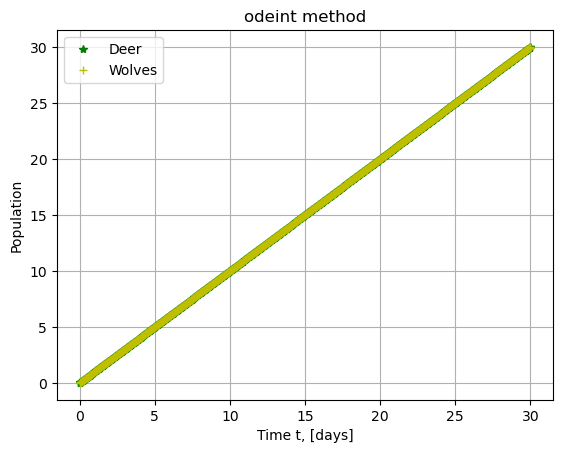

In [39]:

plt.figure()
plt.grid()
plt.title("odeint method")
plt.plot(t_span, g, '*g', label = 'Deer')
plt.plot(t_span, f, '+y', label = "Wolves")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()

plt.show()


Let's think about a general Model which can be used to model a physical system. Consider example of Lotka Volterra System. It has 2 equation.
Similarly a system will have `n` number of differential equations, which will define dynamics of the system. Let's look more deeply into cases possible.
1. Each variable is dependent upon t, which acts as a parameter here
2. More general case, variables might depend on each other. In differential equation systems we are given initial values and asked to solve a problem with them. For example :
    # 1
    ```The volume of a cube is increasing at the rate of 8 cm3/s. How fast is the surface area increasing when the length of its edge is 12 cm? ```
    Here, the variable is edge (say x), the rate of change of surface area (required output) is 3x^2

    To solve it with a neural ode, our neural network should have learned 3x^2 function, and upon inputting x, should output corresponding rate of change
    of surface area.
    d(out)/dx = 3*x**2
    

    # 2
    ``` The length x of a rectangle is decreasing at the rate of 5 cm/min and the width y is increasing at the rate of 4 cm/min. When x = 8 cm and y = 6 cm, find the rate of change of (i) the perimeter (ii) area of rectangle```

    dL/dt = 5, db/dt = 4
    Required answer :
    dPerimeter/dt = d(2*(L+b))/dt = 2*dL/dt + 2*db/dt,
    dArea/dt = L*db/dt + b*dL/dt,

    To solve it with neural ode, the inputs should be L, b, dL/dt, db/dt, and the output should be two neurons, one returning rate of perimeter change, and one returning rate of area change

    In general physical system, inputs and outputs to the system are given, our model has to learn the dynamics and return the output for an unknown input

    Now I am wondering what's the use of an ode solver here ?
    Can't we just use a simple neural network to model the system?


    



With ODE Solvers we are trying to solve differntial equations of the systems, which depend on time, and we solve it over a time span.
For now we'll try to solve these equations only.

There are also problems, in which sometimes x,t is given, y is asked;  y,t is given x is asked; or x,y is given something else is asked

In odes we integrate wrt one variable that means, x and y are function of t


In [ ]:
class NeuralODE(TorchModel):
    